In [1]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=8c735765add0c9b2e14221773b505861c232d6bb3def94c8c93871c986a3aadb
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
import re
import pandas as pd
import nltk
from nltk.corpus import gutenberg
from gensim.parsing.preprocessing import remove_stopwords
import urllib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn import metrics
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import  wordnet
from nltk.stem import WordNetLemmatizer, LancasterStemmer, PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import wordcloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import mixture

import sys

import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
# from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from gensim.test.utils import get_tmpfile
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

# **Books Selection**

This method downloads book from url and returns the book text only

In [4]:
def get_book_txt(book_url):
  response = urllib.request.urlopen(book_url)
  # Read url of the book
  book_data = response.read().decode('utf-8')
  #convert book binary data to string
  book_txt = str(book_data)
  #skip the text added before and after the actual book content
  book_txt_parts = re.split(r"\*\*\* .* \*\*\*", book_txt, 3)
  return book_txt_parts[1]

Downloading the selected books

In [5]:
books_lst = [("https://www.gutenberg.org/files/1661/1661-0.txt","Arthur Conan Doyle","a","The Adventures of Sherlock Holmes"),
             ("https://www.gutenberg.org/cache/epub/1228/pg1228.txt","Charles Darwin","b","On the Origin of Species By Means of Natural Selection"),
             ("https://www.gutenberg.org/cache/epub/25267/pg25267.txt","Camille Flammarion","c","Astronomy for Amateurs"),
             ("https://www.gutenberg.org/files/24518/24518-0.txt","Mackay","d","Memoirs of Extraordinary Popular Delusions and the Madness of Crowds"),
             ("https://www.gutenberg.org/files/17321/17321-0.txt","Harry Reginald, Leonard William","e","History of Egypt, Chaldea, Syria, Babylonia, and Assyria ...")]
books_txt=dict()
for book_info in books_lst:
  #download the book and add it to dictionary
  books_txt[book_info[2]] = get_book_txt(book_info[0])


## Visualizing selected books

**Word Cloud Visualization**

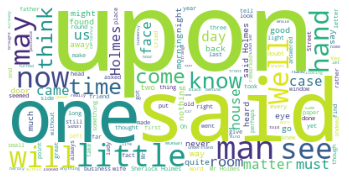

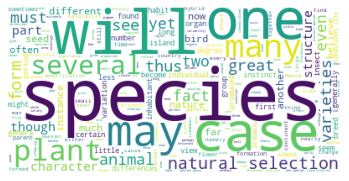

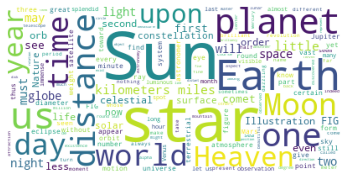

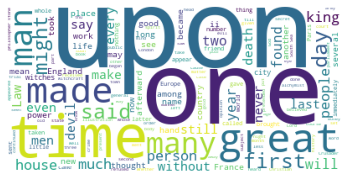

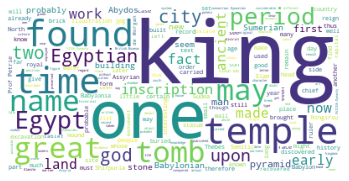

In [6]:
for book_info in books_lst:
  wc = WordCloud(background_color ='white').generate(str(books_txt[book_info[2]]))
  fig = plt.figure(figsize = (6, 6),num=1)
  plt.axis('off')
  plt.imshow(wc, cmap=None)
  plt.show()


# **Creating Books Dataset**

This method prepares the passed book text by removing stop words and punctuation marks then dividing it to paritions

In [7]:
def get_book_part(book_txt,rm_stop_words,flg_stemm, flg_lemm,no_words_part,no_part):
  if len(book_txt) == 0 or no_words_part <=0 or no_part <= 0:
    raise Exception("Invalid arguments sent to get_book_part function")
  
  book_words = word_tokenize(book_txt)
  filtered_book_words = book_words
  
  # removing punctuation marks and keeping words only, using code from https://stackoverflow.com/a/41024113
  filtered_book_words=[word.lower() for word in filtered_book_words if word.isalpha()]
  
  #stemm the words
  if flg_stemm == True:
    stemmer = LancasterStemmer()
    filtered_book_words = [stemmer.stem(w) for w in filtered_book_words]
                
  # Lemmatize the words(convert the word into root word)
  if flg_lemm == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    filtered_book_words = [lem.lemmatize(word) for word in filtered_book_words]
  
  #remove stop words from the book text, using code from https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
  if rm_stop_words:
    stop_words = set(stopwords.words('english'))
    filtered_book_words = [w for w in filtered_book_words if not w.lower() in stop_words]

  part_lst = []
  part = []
  #skipping the first 500 words to skip introduction and TOC
  for word in filtered_book_words[100:]:
    #check if the word is a valid word
    part.append(word)
    if len(part) == no_words_part:
      part_lst.append(part)
      # print(" ".join(part)) #prints part sentence
      part = []
      if len(part_lst) == no_part:
        break  
  #if the part is not empty, then the words were not enough to create a full part
  if len(part)>0:
    print("WARNING: book words were not enough to create full partitions")
  return part_lst


This method appends passed books paritions to passed dataframe

In [8]:
#appends passed book partitions to dataframe
def add_parts_to_dataframe(parts,label,df):
  rows_lst = []
  for part in parts:
    rows_lst.append(pd.Series([part, label] ,index=df.columns))
  df = df.append(rows_lst,ignore_index=True)
  return df

**Creating the books partitions and appending data to dataframe**

In [9]:
#Downloads book from gutenburg, partitions and appends partition to passed dataframe
def part_books_and_append_df(books_info_lst,books_txt_lst,books_df,no_words_part=100,no_part=200,rm_stop_words=False,flg_stemm=True, flg_lemm=False):
  for book_info in books_info_lst:
    print(f"Processing book {book_info[3]}"+"...")
    book_parts = get_book_part(books_txt_lst[book_info[2]],rm_stop_words,flg_stemm,flg_lemm,no_words_part,no_part)
    if len(book_parts) < no_part:
      print(f"WARNING: Text book words were not sufficient to create requested partitions, Only {len(book_parts)} partition were created, \nPartitions wont be added to the final result\n")
      continue
    else:
      books_df = add_parts_to_dataframe(book_parts,book_info[2],books_df)
    print("book paritiones added to dataframe successfully.\n")
  return books_df

In [10]:
no_words_part=150
no_part=200
books_df = pd.DataFrame(columns=['Partition','Label'])
books_df = part_books_and_append_df(books_lst,books_txt,books_df,no_words_part,no_part,True,False,False)

#shuffling books data
books_df = books_df.sample(frac=1,ignore_index=True,random_state=1)
#add a new col that contains the joined paritioned text
books_df['Partition Text'] = books_df['Partition'].str.join(" ")
display(books_df)

Processing book The Adventures of Sherlock Holmes...
book paritiones added to dataframe successfully.

Processing book On the Origin of Species By Means of Natural Selection...
book paritiones added to dataframe successfully.

Processing book Astronomy for Amateurs...
book paritiones added to dataframe successfully.

Processing book Memoirs of Extraordinary Popular Delusions and the Madness of Crowds...
book paritiones added to dataframe successfully.

Processing book History of Egypt, Chaldea, Syria, Babylonia, and Assyria ......
book paritiones added to dataframe successfully.



,Partition,Label,Partition Text
0,"[race, time, romans, pliny, made, curious, dis...",c,race time romans pliny made curious distinctio...
1,"[government, various, parts, egypt, course, la...",e,government various parts egypt course large nu...
2,"[detects, three, others, times, ancient, greek...",c,detects three others times ancient greeks seve...
3,"[pigeon, including, two, three, geographical, ...",b,pigeon including two three geographical races ...
4,"[becomes, obvious, domestic, races, show, adap...",b,becomes obvious domestic races show adaptation...
...,...,...,...
995,"[breast, unfortunate, youth, learned, read, ho...",d,breast unfortunate youth learned read house ne...
996,"[right, hand, sleeve, observed, stained, fresh...",a,right hand sleeve observed stained fresh blood...
997,"[culture, fundamentally, earliest, days, egypt...",e,culture fundamentally earliest days egypt rece...
998,"[quarter, world, improvement, means, generally...",b,quarter world improvement means generally due ...


# **Dataset Exploration and visualization**

## Uni-grams and Bi-grams Visualizations

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


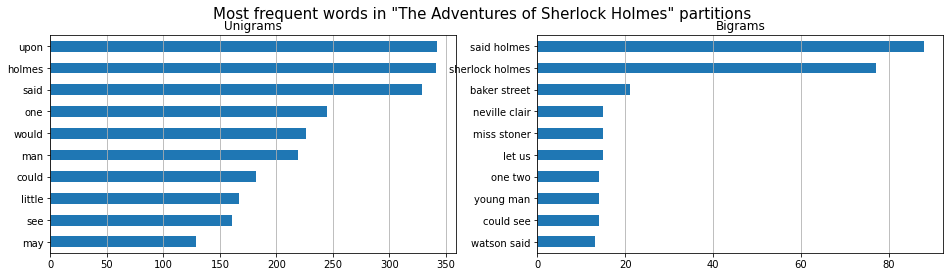

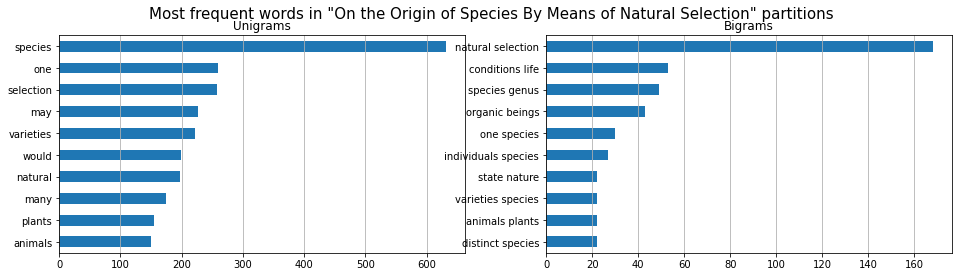

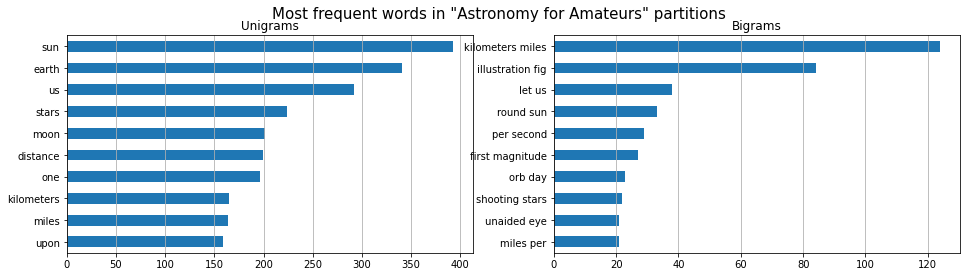

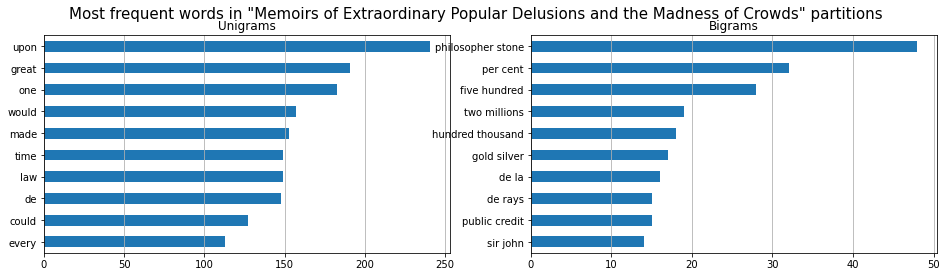

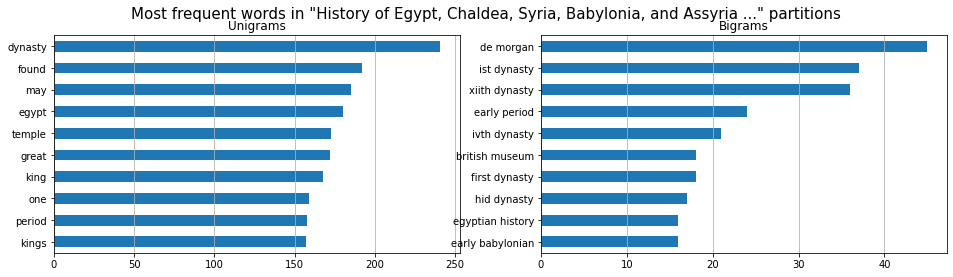

In [11]:
def get_book_name(book_label):
  for book_info in books_lst:
    if book_info[2] == book_label:
      return book_info[-1]
top=10
nltk.download('punkt')
## for vectorizer
from sklearn import feature_extraction, manifold
lis=books_df["Label"].unique()
for i in sorted(lis):
  y=i
  corpus = books_df[books_df["Label"]==y]["Partition Text"]
  lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
  fig.suptitle(f'Most frequent words in "{get_book_name(y)}" partitions', fontsize=15)
  ## unigrams
  dic_words_freq = nltk.FreqDist(lst_tokens)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
  ax[0].set(ylabel=None)
      
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
  dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Bigrams", ax=ax[1],
                    legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.show()

## Using LDA to check topics in book partitions

In [12]:
all_parts = list(books_df['Partition'].values)
# Create Dictionary
id2word = corpora.Dictionary(all_parts)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in all_parts]

In [13]:
num_topics = 20

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

top_topics = lda_model.top_topics(corpus)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.272134 -0.040522       1        1  8.692977
18    -0.106236 -0.327486       2        1  8.535487
16     0.236052 -0.061293       3        1  8.224071
19     0.018131  0.029204       4        1  7.661150
12     0.252494 -0.035580       5        1  7.260192
3     -0.023985  0.088334       6        1  6.480132
13     0.021820  0.082864       7        1  6.460708
10    -0.022509  0.036739       8        1  4.512750
14    -0.102556 -0.240852       9        1  4.380765
0      0.025396  0.056103      10        1  4.334405
4      0.034220  0.026232      11        1  4.325687
1     -0.076419 -0.025512      12        1  4.318651
8     -0.032652  0.046000      13        1  3.811849
2     -0.072978  0.060233      14        1  3.625032
9     -0.090734  0.086349      15        1  3.532163
11    -0.066043  0.014978      16        1  3.192025
15    -0.022127  0.053461      17        1  3.097536
6     -0.061371  0.031931      18        1  2.755592
7     -0.095083  0.054287      19        1  2.590844
17    -0.087555  0.064530      20        1  2.207983, topic_info=         Term        Freq       Total Category  logprob  loglift
440   species  602.000000  602.000000  Default  30.0000  30.0000
417       one  918.000000  918.000000  Default  29.0000  29.0000
837       may  547.000000  547.000000  Default  28.0000  28.0000
1030      sun  429.000000  429.000000  Default  27.0000  27.0000
31      earth  345.000000  345.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
159      dead   45.517071   53.263599  Topic20  -4.2872   3.6559
135      also   39.809788  247.686392  Topic20  -4.4212   1.9850
3931      sea   24.189996   41.823190  Topic20  -4.9194   3.2656
3781     date   23.289021   38.829233  Topic20  -4.9573   3.3019
4134  science   22.370977   44.878084  Topic20  -4.9975   3.1169

[819 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
132      20  0.992917  abydos
3775      1  0.981807  across
462       1  0.986454     act
1045      9  0.978280  action
650      13  0.984311  actual
...     ...       ...     ...
967       1  0.293606     yet
967       3  0.092506     yet
967       5  0.611344     yet
459       3  0.753384   young
459      17  0.237286   young

[935 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 19, 17, 20, 13, 4, 14, 11, 15, 1, 5, 2, 9, 3, 10, 12, 16, 7, 8, 18])

**Adding LDA topics to partitions**

In [15]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(books_df['Partition Text'])
LDA = LatentDirichletAllocation(n_components=num_topics,random_state=42)
LDA.fit(X_train_counts)
topic_results = LDA.transform(X_train_counts)
books_df['Topic'] = topic_results.argmax(axis=1)
books_df.head(10)

,Partition,Label,Partition Text,Topic
0,"[race, time, romans, pliny, made, curious, dis...",c,race time romans pliny made curious distinctio...,2
1,"[government, various, parts, egypt, course, la...",e,government various parts egypt course large nu...,15
2,"[detects, three, others, times, ancient, greek...",c,detects three others times ancient greeks seve...,17
3,"[pigeon, including, two, three, geographical, ...",b,pigeon including two three geographical races ...,4
4,"[becomes, obvious, domestic, races, show, adap...",b,becomes obvious domestic races show adaptation...,4
5,"[another, proportion, trenches, cut, deeper, m...",e,another proportion trenches cut deeper mound s...,15
6,"[distinguished, species, firstly, discovery, i...",b,distinguished species firstly discovery interm...,4
7,"[flints, could, found, desert, surface, beadne...",e,flints could found desert surface beadnell geo...,11
8,"[inhabitants, thus, jostle, closely, shall, ge...",b,inhabitants thus jostle closely shall general ...,4
9,"[dare, conceive, things, really, mere, commonp...",a,dare conceive things really mere commonplaces ...,12


**printing most frequent words in every topic**

In [16]:
frq_words_no = 10

rows_lst=[]

topic_words_col_name = [str(word_idx) for word_idx in range(frq_words_no)]
topics_df = pd.DataFrame(columns=['Topic', *topic_words_col_name])
for idx,single_topic in enumerate(LDA.components_):
    topic_top_words = [count_vect.get_feature_names()[i] for i in single_topic.argsort()[-(frq_words_no):]]
    rows_lst.append(pd.Series([idx, *topic_top_words] ,index=topics_df.columns))
topics_df = topics_df.append(rows_lst,ignore_index=True)

display(topics_df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,0,1,2,3,4,5,6,7,8,9
0,0,de,hybrids,great,john,upon,house,sterility,caricature,print,time
1,1,one,times,would,distance,upon,planet,moon,us,earth,sun
2,2,may,comet,might,angle,like,two,year,degree,great,one
3,3,much,beak,great,tumbler,carrier,marks,fantail,tail,several,breeds
4,4,would,many,animals,plants,natural,may,one,varieties,selection,species
5,5,second,distance,us,first,kilometers,magnitude,miles,one,star,stars
6,6,salesman,les,de,new,much,upon,witness,geese,would,time
7,7,stock,made,great,time,hundred,company,one,law,would,upon
8,8,well,see,little,could,would,man,one,upon,said,holmes
9,9,albert,basil,relative,rule,applies,left,light,marks,view,length


# **Feature Engineering**

## **BOW**

In [17]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(books_df['Partition Text'])
#printing BOW feature matrix
tokens= count_vect.get_feature_names()
doc_names = ['Part{:d}'.format(idx) for idx, _ in enumerate(X_train_counts)]
df = pd.DataFrame(data=X_train_counts.toarray(), index=doc_names, columns=tokens)
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ab,abadiya,abandon,abandoned,abandoning,abandons,abated,abbey,abbot,abbots,...,zèle,âge,æsculapius,égal,égypte,équipage,étoiles,êtes,ûn,œuvre
Part0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Part1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Part2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Part3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Part4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Part995,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Part996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Part997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Part998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **TF-IDF**

In [18]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.toarray()
df_idf = pd.DataFrame(tf_transformer.idf_, index=tokens,columns=["idf_weights"])
display(df_idf['idf_weights'].nlargest(n=1000))

abadiya           7.215608
abandon           7.215608
abandoning        7.215608
abated            7.215608
abbots            7.215608
                    ...   
champignelle      7.215608
chancellorship    7.215608
chandeliers       7.215608
chandos           7.215608
channels          7.215608
Name: idf_weights, Length: 1000, dtype: float64

## **Word Embedding**

In [19]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate (books_df['Partition'])]
doc2vec_model = Doc2Vec(documents, min_count=1,seed=1)
fname = get_tmpfile("my_doc2vec_model")
doc2vec_model.save(fname)
doc2vec_model = Doc2Vec.load(fname)
doc2vec_vectors = []
for i in range(len(books_df['Partition'])):
 vector = doc2vec_model.infer_vector(books_df['Partition'].iloc[i])
 doc2vec_vectors.append(vector)
# print(vectors)
# np.array(vectors).shape

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


## **LDA**

In [20]:
count_vect = CountVectorizer()
trans_part_txt = count_vect.fit_transform(books_df['Partition Text'])
model = LatentDirichletAllocation(n_components=num_topics,random_state=42)
model.fit(trans_part_txt)
lda_output = model.transform(trans_part_txt)

# column names
topicnames = ["Topic" + str(i) for i in range(num_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(books_df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
display(df_document_topic)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.0,0.23,0.76,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,2
Doc1,0.0,0.00,0.00,0.00,0.00,0.18,0.0,0.00,0.00,0.00,...,0.28,0.20,0.0,0.00,0.34,0.0,0.00,0.0,0.0,15
Doc2,0.0,0.32,0.00,0.00,0.00,0.27,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.0,0.40,0.0,0.0,17
Doc3,0.0,0.00,0.00,0.00,0.58,0.00,0.0,0.00,0.00,0.41,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,4
Doc4,0.0,0.00,0.00,0.15,0.64,0.00,0.0,0.00,0.00,0.00,...,0.00,0.19,0.0,0.00,0.00,0.0,0.00,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc995,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,10
Doc996,0.0,0.00,0.00,0.00,0.00,0.29,0.0,0.06,0.65,0.00,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,8
Doc997,0.0,0.00,0.00,0.00,0.00,0.02,0.0,0.00,0.00,0.00,...,0.13,0.00,0.0,0.55,0.00,0.0,0.29,0.0,0.0,14
Doc998,0.0,0.00,0.00,0.00,0.55,0.00,0.0,0.45,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,4


# **Clustering Models**

In [21]:
#helper method to return a dataframe that includes the mapping between clusters and original part labels
def get_cluster_labels(cluster_names,books_df):
  model_pred_df = books_df[['Partition Text', 'Label']].copy(deep=True)
  model_pred_df['Cluster Name']=cluster_names
  model_pred_df['Cluster Label'] = model_pred_df['Cluster Name'].astype(str)

  for cluster_name in cluster_names:
    cluster_label = books_df.loc[cluster_names == cluster_name]['Label'].value_counts().idxmax()
    model_pred_df = model_pred_df.replace({'Cluster Label': f'{cluster_name}'}, cluster_label)  
  return model_pred_df

def draw_cluster_scatter(features,pred_clust):
  clusters_names = set(pred_clust)
  plt.figure(figsize=(12,6))
  #draw the Scatter
  X_tSne = TSNE(n_components=2).fit_transform(features)
  X_tSne = pd.concat([pd.DataFrame(X_tSne).astype(float), pd.DataFrame(pred_clust).astype(int)], axis=1 , ignore_index=True)

  for cluster_name in clusters_names:
      plt.scatter(X_tSne[X_tSne[2]==cluster_name][0] , X_tSne[X_tSne[2] == cluster_name][1], s=10, label = f'cluster {cluster_name}')
  plt.xlabel('X Value')
  plt.ylabel('y Value')
  plt.legend()
  plt.show()

## K-Means

### BOW

#### Selecting best number of clusters

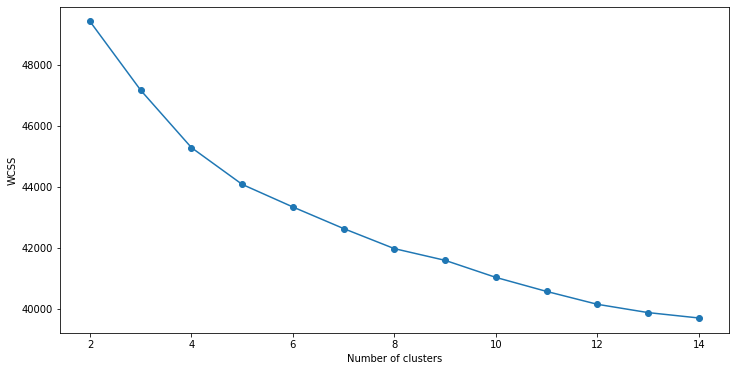

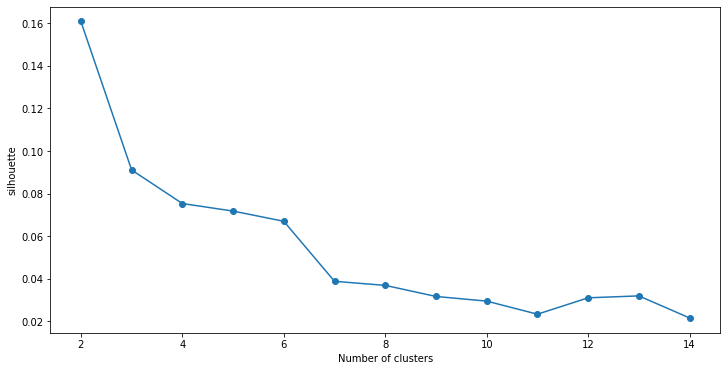

In [22]:
count_vect = CountVectorizer(min_df=100)
part_txt_trans = count_vect.fit_transform(books_df['Partition Text'])

max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(part_txt_trans)
    cluster_num.append(i)
    sil_err.append(silhouette_score(part_txt_trans, kmeans.labels_))
    wcss_err.append( kmeans.inertia_ )

plt.figure(figsize=(12,6))
plt.plot( cluster_num, wcss_err, marker = "o" )
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 5**

#### Model

In [23]:
text_clus_KMeans = Pipeline([
    ('vect', CountVectorizer(min_df=100)),
    ('estimator', KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)),
])
text_clus_KMeans.fit(books_df['Partition Text'])

#evaluation
#kappa
Kmeans_df = get_cluster_labels(text_clus_KMeans['estimator'].labels_,books_df)
print(f"Kappa score: {cohen_kappa_score(Kmeans_df['Label'], Kmeans_df['Cluster Label'])}")
#coherence
print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
parts_txt_trans = text_clus_KMeans['vect'].transform(books_df['Partition Text'].values)
print(f"Silhouette score: {silhouette_score(parts_txt_trans, text_clus_KMeans['estimator'].labels_)}")

Kappa score: 0.5825
Coherence score: 44080.84693585318
Silhouette score: 0.07174816287630997


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


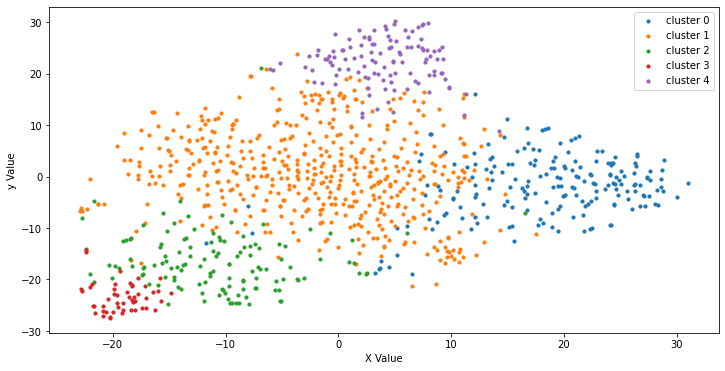

In [24]:
draw_cluster_scatter(parts_txt_trans,text_clus_KMeans['estimator'].labels_)

### TF-IDF

#### Selecting best number of clusters

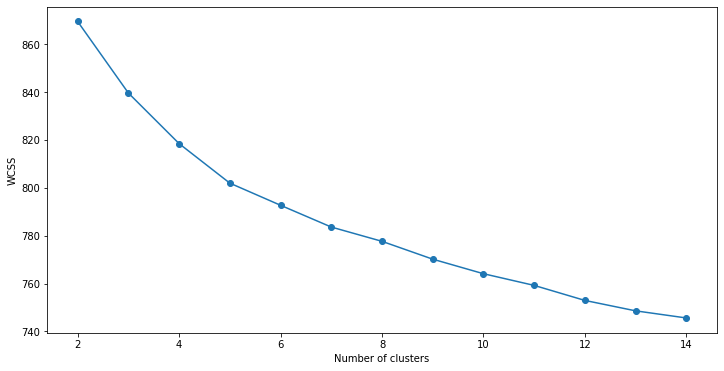

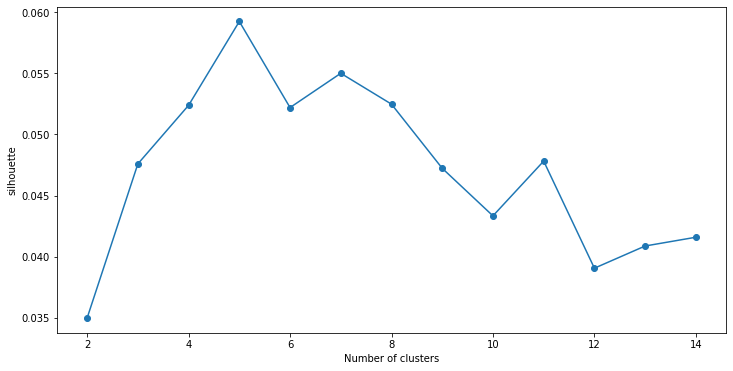

In [25]:
vectorizer_s = TfidfVectorizer(min_df=50)
part_txt_trans = vectorizer_s.fit_transform(books_df['Partition Text'])
max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(part_txt_trans)
    cluster_num.append(i)
    sil_err.append(silhouette_score(part_txt_trans, kmeans.labels_))
    wcss_err.append( kmeans.inertia_ )

plt.figure(figsize=(12,6))
plt.plot( cluster_num, wcss_err, marker = "o" )
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 5**

#### Model

In [26]:
text_clus_KMeans = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=50)),
    ('estimator', KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)),
])
text_clus_KMeans.fit(books_df['Partition Text'])

#evaluation
#kappa
Kmeans_df = get_cluster_labels(text_clus_KMeans['estimator'].labels_,books_df)
print(f"Kappa score: {cohen_kappa_score(Kmeans_df['Label'], Kmeans_df['Cluster Label'])}")
#coherence
print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
parts_txt_trans = text_clus_KMeans['tfidf'].transform(books_df['Partition Text'].values)
print(f"Silhouette score: {silhouette_score(parts_txt_trans, text_clus_KMeans['estimator'].labels_)}")

Kappa score: 0.96125
Coherence score: 801.9525556221204
Silhouette score: 0.059234233099560926


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


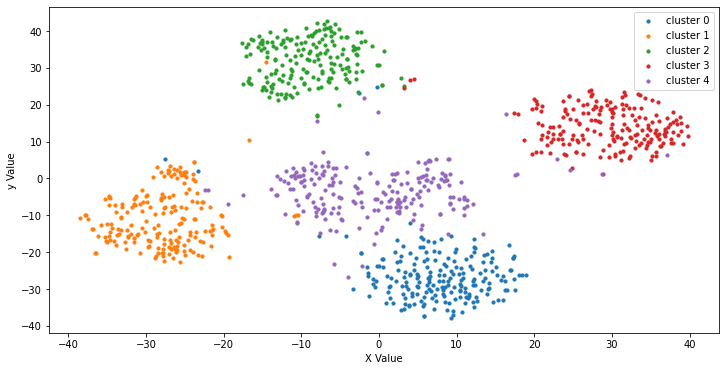

In [27]:
draw_cluster_scatter(parts_txt_trans,text_clus_KMeans['estimator'].labels_)

### Word embbedding

#### Selecting best number of clusters

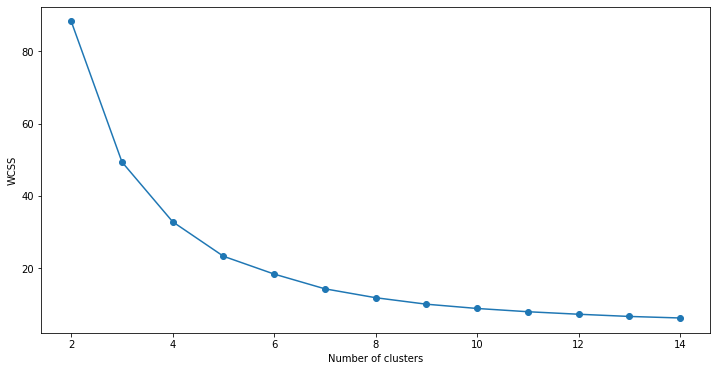

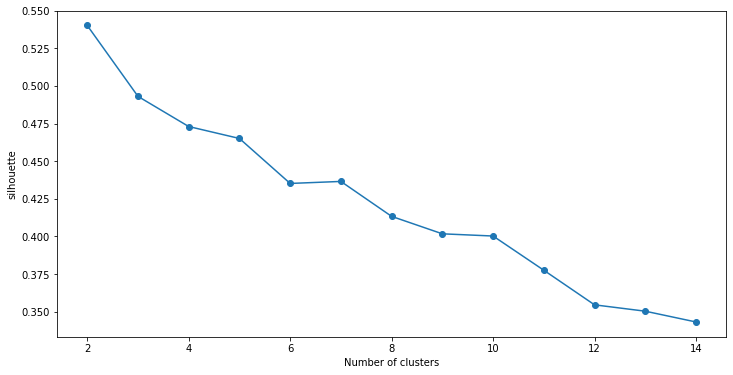

In [28]:
max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(doc2vec_vectors)
    cluster_num.append(i)
    sil_err.append(silhouette_score(doc2vec_vectors, kmeans.labels_))
    wcss_err.append( kmeans.inertia_ )

plt.figure(figsize=(12,6))
plt.plot( cluster_num, wcss_err, marker = "o" )
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 4**

#### Model

In [29]:
text_clus_KMeans = Pipeline([
    ('estimator', KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)),
])
text_clus_KMeans.fit(doc2vec_vectors)

#evaluation
#kappa
Kmeans_df = get_cluster_labels(text_clus_KMeans['estimator'].labels_,books_df)
print(f"Kappa score: {cohen_kappa_score(Kmeans_df['Label'], Kmeans_df['Cluster Label'])}")
#coherence
print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(doc2vec_vectors, text_clus_KMeans['estimator'].labels_)}")

Kappa score: 0.18125000000000002
Coherence score: 32.79963513985955
Silhouette score: 0.4729914665222168


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


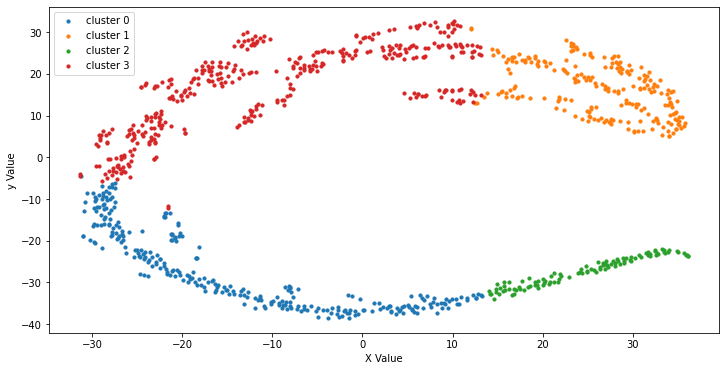

In [30]:
draw_cluster_scatter(doc2vec_vectors,text_clus_KMeans['estimator'].labels_)

###  LDA

#### Selecting best number of clusters

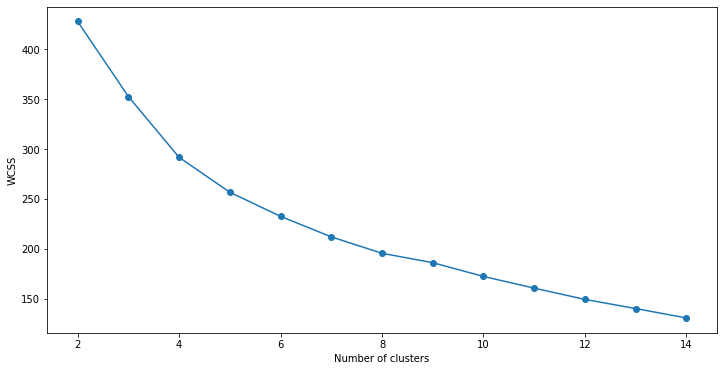

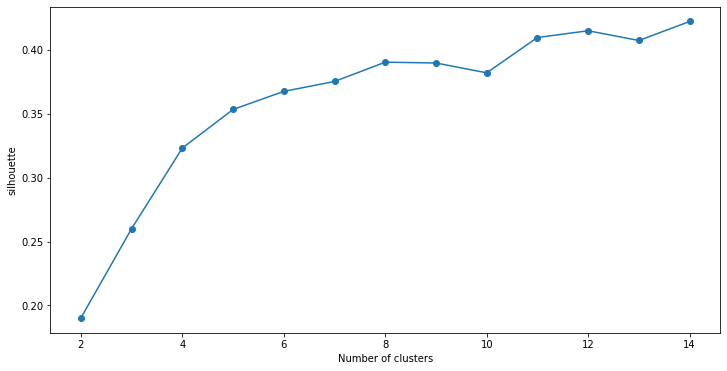

In [31]:
count_vect = CountVectorizer()
trans_part_txt = count_vect.fit_transform(books_df['Partition Text'])
model = LatentDirichletAllocation(n_components=num_topics,random_state=42)
model.fit(trans_part_txt)
part_txt_trans = model.transform(trans_part_txt)

max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(part_txt_trans)
    cluster_num.append(i)
    sil_err.append(silhouette_score(part_txt_trans, kmeans.labels_))
    wcss_err.append( kmeans.inertia_ )

plt.figure(figsize=(12,6))
plt.plot( cluster_num, wcss_err, marker = "o" )
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 8**

#### Model

In [32]:
text_clus_KMeans = Pipeline([
    ('vect', CountVectorizer(min_df=50)),
    ('lda', LatentDirichletAllocation(n_components=num_topics,random_state=42)),
    ('estimator', KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)),
])
text_clus_KMeans.fit(books_df['Partition Text'])

#evaluation
#kappa
Kmeans_df = get_cluster_labels(text_clus_KMeans['estimator'].labels_,books_df)
print(f"Kappa score: {cohen_kappa_score(Kmeans_df['Label'], Kmeans_df['Cluster Label'])}")
#coherence
print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
parts_txt_trans = text_clus_KMeans['vect'].transform(books_df['Partition Text'])    
parts_txt_trans = text_clus_KMeans['lda'].transform(parts_txt_trans)
print(f"Silhouette score: {silhouette_score(parts_txt_trans, text_clus_KMeans['estimator'].labels_)}")

Kappa score: 0.72875
Coherence score: 245.9642478337185
Silhouette score: 0.34222399064426384


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


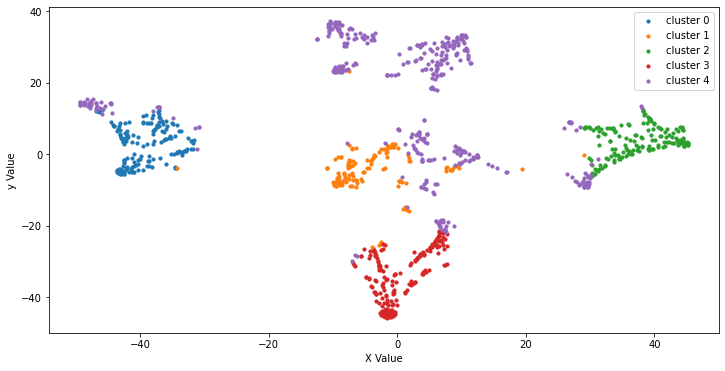

In [33]:
draw_cluster_scatter(parts_txt_trans,text_clus_KMeans['estimator'].labels_)

## EM

In [34]:
#utility function to help in getting best nu,ber of compnents in SVD, from following link 
#https://chrisalbon.com/code/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/
# Create a function
def select_n_components(trans_txt_part,var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

def get_reduced_transformed_txt_part(trans_txt_part):
    #getting the best number of compnents for svd
    tsvd = TruncatedSVD(n_components=trans_txt_part.shape[1]-1,random_state=0)
    X_tsvd = tsvd.fit(trans_txt_part)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    selected_n_components = select_n_components(trans_txt_part,tsvd_var_ratios, 0.95)
#     print(str(selected_n_components))

    #reduce the input vectors dimensions
    np.random.seed(0)
    trans_txt_part = csr_matrix(trans_txt_part)
    svd = TruncatedSVD(n_components=selected_n_components, n_iter=10, random_state=42)
    svd.fit(trans_txt_part)
    reduced_trans_part = svd.transform(trans_txt_part)
    return reduced_trans_part


###  BOW

#### Selecting best number of clusters

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

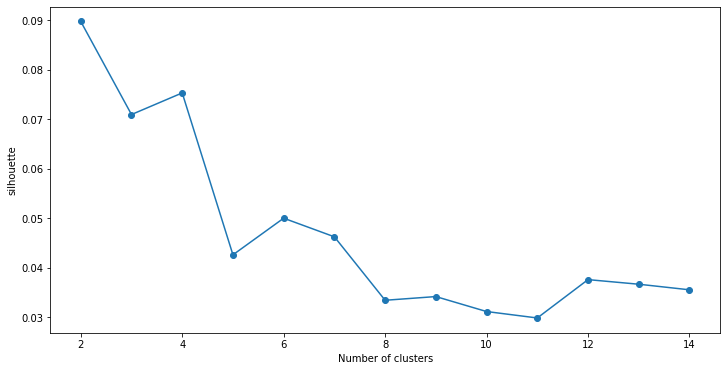

In [35]:
vectorizer_s = CountVectorizer(min_df=100)
trans_txt_part = vectorizer_s.fit_transform(books_df['Partition Text'])

reduced_trans_part = get_reduced_transformed_txt_part(trans_txt_part)

max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='tied',max_iter=100,init_params='kmeans',random_state=0)
    gmm.fit(reduced_trans_part)
    pred_clust=gmm.predict(reduced_trans_part)

    cluster_num.append(i)
    sil_err.append(silhouette_score(reduced_trans_part, pred_clust))


plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 4**

#### Model

In [36]:
cluster_num = 4
#train the model
gmm = mixture.GaussianMixture(n_components=cluster_num, covariance_type='tied',max_iter=100,init_params='kmeans',random_state=0)
gmm.fit(reduced_trans_part)
pred_clust=gmm.predict(reduced_trans_part)
# print(str(pred_clust))
#kappa
EM_df = get_cluster_labels(pred_clust,books_df)
print(f"Kappa score: {cohen_kappa_score(EM_df['Label'], EM_df['Cluster Label'])}")
#coherence
# print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(reduced_trans_part, pred_clust)}")

Kappa score: 0.47875
Silhouette score: 0.0753171425476114


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


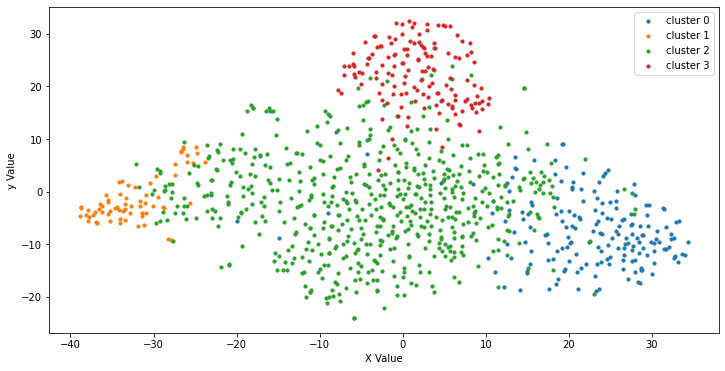

In [37]:
draw_cluster_scatter(reduced_trans_part,pred_clust)

###  TF-IDF

#### Selecting best number of clusters

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

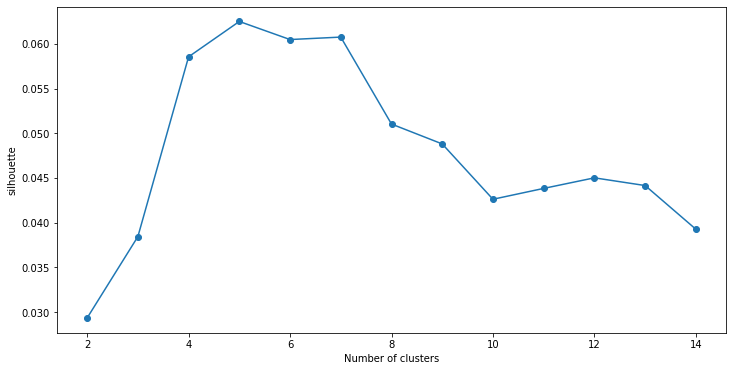

In [38]:
vectorizer_s = TfidfVectorizer(min_df=50)
part_txt_trans = vectorizer_s.fit_transform(books_df['Partition Text'])

reduced_trans_part = get_reduced_transformed_txt_part(part_txt_trans)

max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='tied',max_iter=100,init_params='kmeans',random_state=0)
    gmm.fit(reduced_trans_part)
    pred_clust=gmm.predict(reduced_trans_part)

    cluster_num.append(i)
    sil_err.append(silhouette_score(reduced_trans_part, pred_clust))


plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 5**

#### Model

In [39]:
clusters_num = 5
#train the model
gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied',max_iter=100,init_params='kmeans',random_state=0)
gmm.fit(reduced_trans_part)
pred_clust=gmm.predict(reduced_trans_part)
# print(str(pred_clust))
#kappa
EM_df = get_cluster_labels(pred_clust,books_df)
print(f"Kappa score: {cohen_kappa_score(EM_df['Label'], EM_df['Cluster Label'])}")
#coherence
# print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(reduced_trans_part, pred_clust)}")

Kappa score: 0.96125
Silhouette score: 0.06249725400943369


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


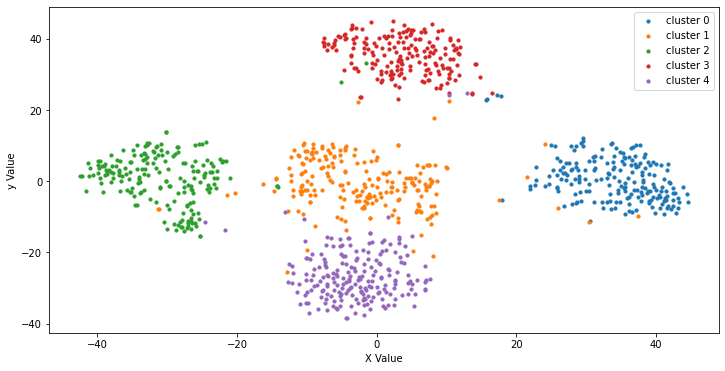

In [40]:
draw_cluster_scatter(reduced_trans_part,pred_clust)

###  Word Embbedding

#### Selecting best number of clusters

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


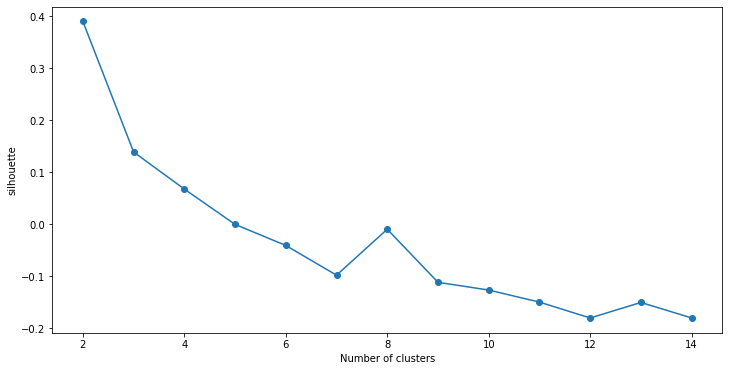

In [41]:
اmax_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    cluster_num.append(i)
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='tied',max_iter=100,init_params='kmeans',random_state=0)
    gmm.fit(doc2vec_vectors)
    pred_clust=gmm.predict(doc2vec_vectors)
    sil_err.append(silhouette_score(doc2vec_vectors, pred_clust))

plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 4**

#### Model

In [42]:
clusters_num = 4
#train the model
gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied',max_iter=100,init_params='kmeans',random_state=0)
gmm.fit(doc2vec_vectors)
pred_clust=gmm.predict(doc2vec_vectors)

#kappa
EM_df = get_cluster_labels(pred_clust,books_df)
print(f"Kappa score: {cohen_kappa_score(EM_df['Label'], EM_df['Cluster Label'])}")
#coherence
# print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(doc2vec_vectors, pred_clust)}")

Kappa score: 0.28874999999999995
Silhouette score: 0.06808120757341385


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


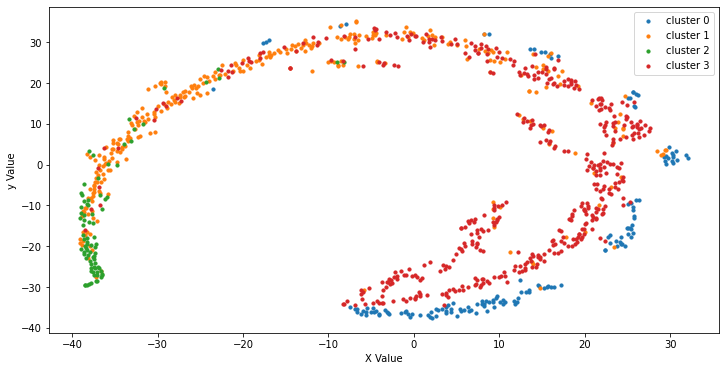

In [43]:
draw_cluster_scatter(doc2vec_vectors,pred_clust)

###  LDA

#### Selecting best number of clusters

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

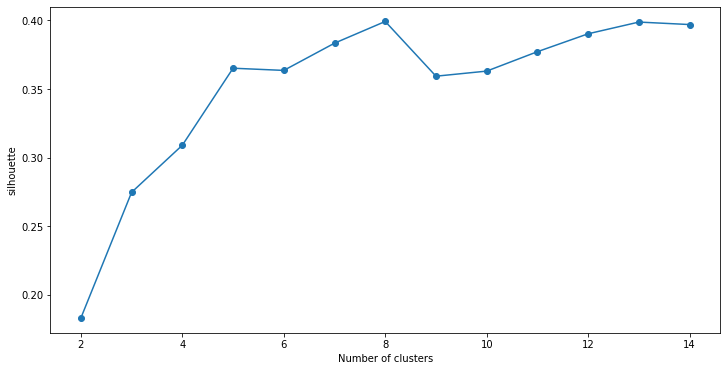

In [44]:
count_vect = CountVectorizer()
trans_part_txt = count_vect.fit_transform(books_df['Partition Text'])
model = LatentDirichletAllocation(n_components=num_topics,random_state=42)
model.fit(trans_part_txt)
trans_txt_part = model.transform(trans_part_txt)

reduced_trans_part = get_reduced_transformed_txt_part(trans_txt_part)

max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    gmm = mixture.GaussianMixture(n_components=i, covariance_type='tied',max_iter=100,init_params='kmeans',random_state=0)
    gmm.fit(reduced_trans_part)
    pred_clust=gmm.predict(reduced_trans_part)

    cluster_num.append(i)
    sil_err.append(silhouette_score(reduced_trans_part, pred_clust))


plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 8**

#### Model

In [45]:
#train the model
gmm = mixture.GaussianMixture(n_components=8, covariance_type='tied',max_iter=100,init_params='kmeans',random_state=0)
gmm.fit(reduced_trans_part)
pred_clust=gmm.predict(reduced_trans_part)
# print(str(pred_clust))
#kappa
EM_df = get_cluster_labels(pred_clust,books_df)
print(f"Kappa score: {cohen_kappa_score(EM_df['Label'], EM_df['Cluster Label'])}")
#coherence
# print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(reduced_trans_part, pred_clust)}")

Kappa score: 0.8362499999999999
Silhouette score: 0.399243497533306


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


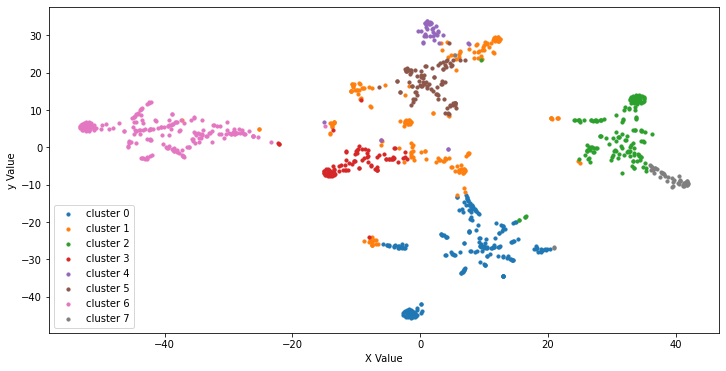

In [46]:
#draw the Scatter
draw_cluster_scatter(reduced_trans_part,pred_clust)

## Hierarchical clustering

###  BOW

#### Selecting best number of clusters

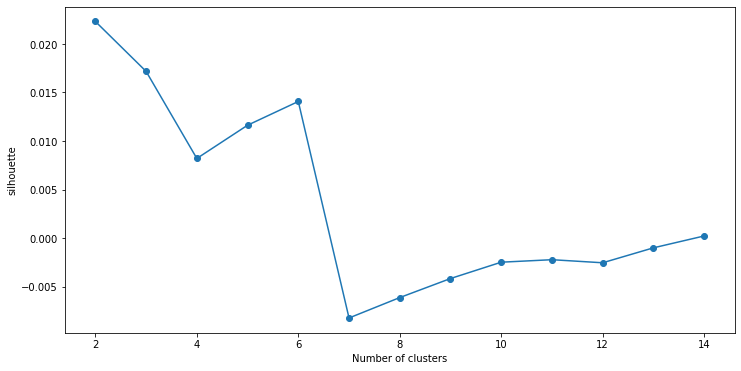

In [47]:
vectorizer = CountVectorizer(max_df=100)
part_txt_trans = vectorizer.fit_transform(books_df['Partition Text'])
X = part_txt_trans.toarray()

max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    # create clusters
    hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage = 'ward')
    # save clusters for chart
    y_hc = hc.fit_predict(X)
    
    cluster_num.append(i)
    sil_err.append(silhouette_score(part_txt_trans, y_hc))


plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 6**

#### Model

In [48]:
clusters_num = 6
vectorizer = CountVectorizer(min_df=100)
X = vectorizer.fit_transform(books_df['Partition Text']).toarray()

# create clusters
hc = AgglomerativeClustering(n_clusters=clusters_num, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(X)

#kappa
Hirarchical_df = get_cluster_labels(y_hc,books_df)
print(f"Kappa score: {cohen_kappa_score(Hirarchical_df['Label'], Hirarchical_df['Cluster Label'])}")
#coherence
# print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(X, y_hc)}")

Kappa score: 0.57
Silhouette score: 0.04271552890500441


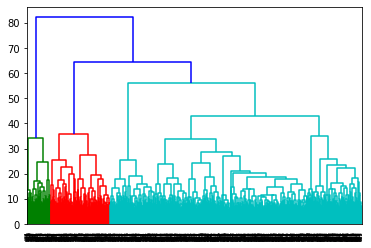

In [49]:
#draw the Hierarchical graph
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(pd.DataFrame(X), method='ward'))


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


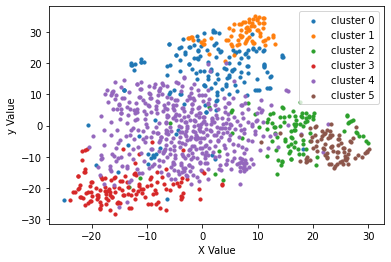

In [50]:
#draw the Scatter
X_bow_tSne = TSNE(n_components=2).fit_transform(X)
X_bow_tSne = pd.concat([pd.DataFrame(X_bow_tSne).astype(float), pd.DataFrame(y_hc).astype(int)], axis=1 , ignore_index=True)

for cluster_name in range(clusters_num):
    plt.scatter(X_bow_tSne[X_bow_tSne[2]==cluster_name][0] , X_bow_tSne[X_bow_tSne[2] == cluster_name][1], s=10, label = f'cluster {cluster_name}')
plt.xlabel('X Value')
plt.ylabel('y Value')
plt.legend()
plt.show()

###  TF-IDF

#### Selecting best number of clusters

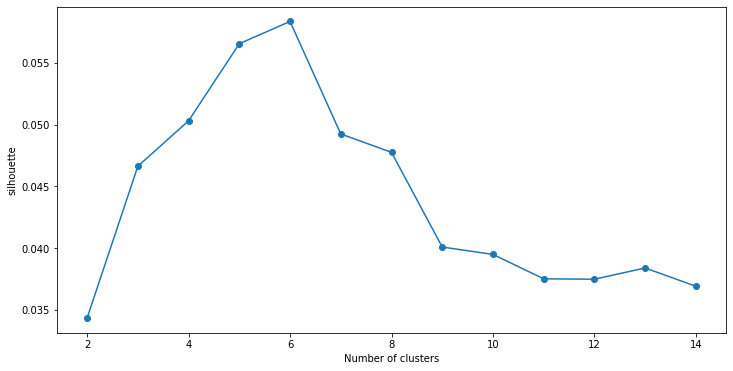

In [51]:
vectorizer_s = TfidfVectorizer(min_df=50)
part_txt_trans = vectorizer_s.fit_transform(books_df['Partition Text'])
X = part_txt_trans.toarray()

max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    # create clusters
    hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage = 'ward')
    # save clusters for chart
    y_hc = hc.fit_predict(X)
    
    cluster_num.append(i)
    sil_err.append(silhouette_score(part_txt_trans, y_hc))


plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 6**

#### Model

In [52]:
clusters_num = 6
vectorizer = TfidfVectorizer()
X1 = vectorizer.fit_transform(books_df['Partition Text']).toarray()

# create clusters
hc = AgglomerativeClustering(n_clusters=clusters_num, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(X1)

#kappa
Hirarchical_df = get_cluster_labels(y_hc,books_df)
print(f"Kappa score: {cohen_kappa_score(Hirarchical_df['Label'], Hirarchical_df['Cluster Label'])}")
#coherence
# print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(X1, y_hc)}")

Kappa score: 0.98875
Silhouette score: 0.02250727234524136


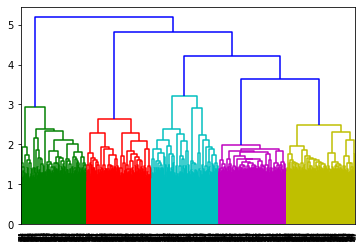

In [53]:
#draw the Hierarchical graph
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(pd.DataFrame(X1), method='ward'))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


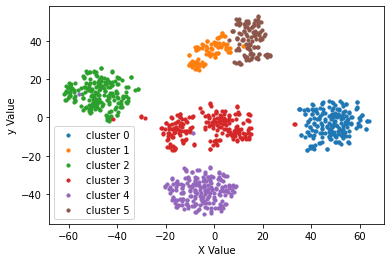

In [54]:
#draw the Scatter
X_tSne = TSNE(n_components=2).fit_transform(X1)
X_tSne = pd.concat([pd.DataFrame(X_tSne).astype(float), pd.DataFrame(y_hc).astype(int)], axis=1 , ignore_index=True)

for cluster_name in range(clusters_num):
    plt.scatter(X_tSne[X_tSne[2]==cluster_name][0] , X_tSne[X_tSne[2] == cluster_name][1], s=10, label = f'cluster {cluster_name}')
plt.xlabel('X Value')
plt.ylabel('y Value')
plt.legend()
plt.show()

###  Word Embbedding

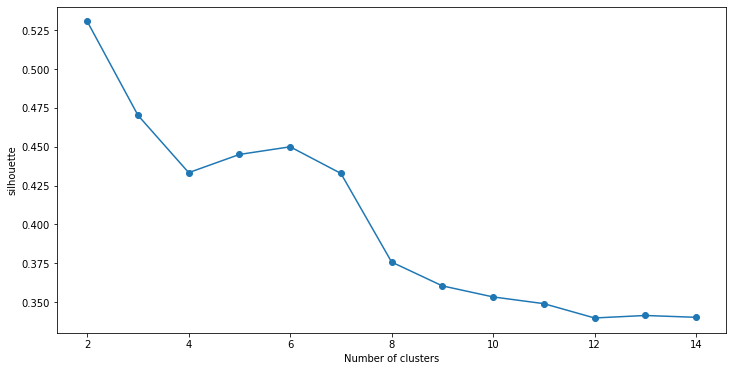

In [55]:
max_k=15
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(2, max_k):
    # create clusters
    hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage = 'ward')
    # save clusters for chart
    y_hc = hc.fit_predict(doc2vec_vectors)
    
    cluster_num.append(i)
    sil_err.append(silhouette_score(doc2vec_vectors, y_hc))


plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

#### Selecting best number of clusters

**From the previous graphs, the best number of clusters = 8**

#### Model

In [56]:
# create clusters
clusters_num = 8
hc = AgglomerativeClustering(n_clusters=clusters_num, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(doc2vec_vectors)

#kappa
Hirarchical_df = get_cluster_labels(y_hc,books_df)
print(f"Kappa score: {cohen_kappa_score(Hirarchical_df['Label'], Hirarchical_df['Cluster Label'])}")
#coherence
# print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(doc2vec_vectors, y_hc)}")

Kappa score: 0.1775
Silhouette score: 0.3757501244544983


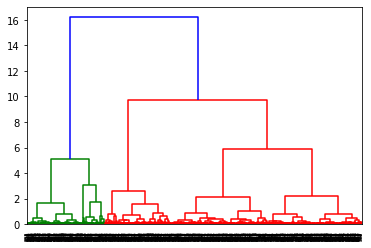

In [57]:
#draw the Hierarchical graph
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(pd.DataFrame(doc2vec_vectors), method='ward'))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


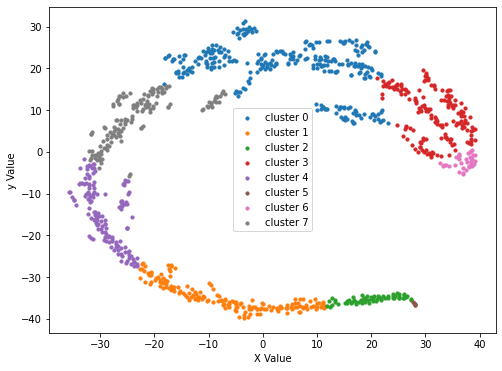

In [58]:
#draw the Scatter
X_tSne = TSNE(n_components=2).fit_transform(doc2vec_vectors)
X_tSne = pd.concat([pd.DataFrame(X_tSne).astype(float), pd.DataFrame(y_hc).astype(int)], axis=1 , ignore_index=True)
plt.figure(figsize=(8,6))

for cluster_name in range(clusters_num):
    plt.scatter(X_tSne[X_tSne[2]==cluster_name][0] , X_tSne[X_tSne[2] == cluster_name][1], s=10, label = f'cluster {cluster_name}')

plt.xlabel('X Value')
plt.ylabel('y Value')
plt.legend()
plt.show()

###  LDA

#### Selecting best number of clusters

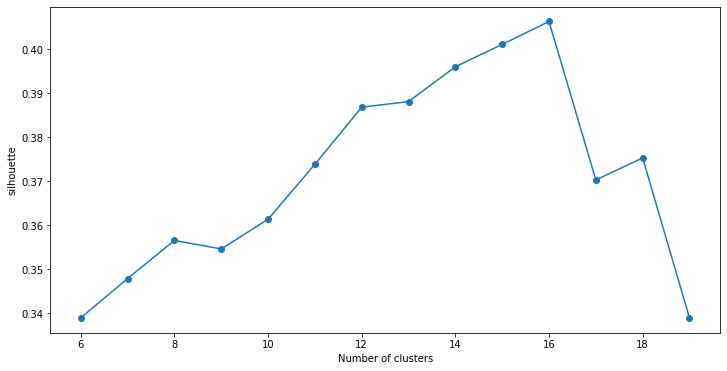

In [59]:
count_vect = CountVectorizer()
trans_part_txt = count_vect.fit_transform(books_df['Partition Text'])
model = LatentDirichletAllocation(n_components=num_topics,random_state=42)
model.fit(trans_part_txt)
part_txt_trans = model.transform(trans_part_txt)

max_k=20
cluster_num = []
#WCSS
wcss_err = []
#silhouette
sil_err = []

for i in range(6, max_k):
    # create clusters
    hc = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage = 'ward')
    # save clusters for chart
    y_hc = hc.fit_predict(part_txt_trans)
    
    cluster_num.append(i)
    sil_err.append(silhouette_score(part_txt_trans, y_hc))


plt.figure(figsize=(12,6))
plt.plot(cluster_num, sil_err, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()

**From the previous graphs, the best number of clusters = 16**

#### Model

In [60]:
clusters_num = 16
count_vect = CountVectorizer()
trans_part_txt = count_vect.fit_transform(books_df['Partition Text'])
model = LatentDirichletAllocation(n_components=num_topics,random_state=42)
model.fit(trans_part_txt)
part_txt_trans = model.transform(trans_part_txt)

# create clusters
hc = AgglomerativeClustering(n_clusters=clusters_num, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(part_txt_trans)

#kappa
Hirarchical_df = get_cluster_labels(y_hc,books_df)
print(f"Kappa score: {cohen_kappa_score(Hirarchical_df['Label'], Hirarchical_df['Cluster Label'])}")
#coherence
# print(f"Coherence score: {text_clus_KMeans['estimator'].inertia_}")
#silhoutte
print(f"Silhouette score: {silhouette_score(part_txt_trans, y_hc)}")

Kappa score: 0.86625
Silhouette score: 0.4063031226347956


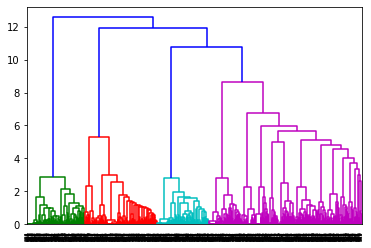

In [61]:
#draw the Hierarchical graph
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(pd.DataFrame(part_txt_trans), method='ward'))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


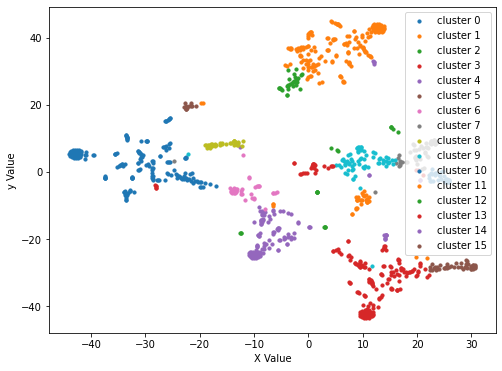

In [62]:
#draw the Scatter
X_tSne = TSNE(n_components=2).fit_transform(part_txt_trans)
X_tSne = pd.concat([pd.DataFrame(X_tSne).astype(float), pd.DataFrame(y_hc).astype(int)], axis=1 , ignore_index=True)

plt.figure(figsize=(8,6))
for cluster_name in range(clusters_num):
    plt.scatter(X_tSne[X_tSne[2]==cluster_name][0] , X_tSne[X_tSne[2] == cluster_name][1], s=10, label = f'cluster {cluster_name}')

plt.xlabel('X Value')
plt.ylabel('y Value')
plt.legend()
plt.show()

# **Best Model**

# **Error Analysis**

In [63]:
clusters_num = 6
vectorizer = TfidfVectorizer()
X1 = vectorizer.fit_transform(books_df['Partition Text']).toarray()

# create clusters
hc = AgglomerativeClustering(n_clusters=clusters_num, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(X1)

#kappa
Hirarchical_df = get_cluster_labels(y_hc,books_df)
# print(f"Kappa score: {cohen_kappa_score(Hirarchical_df['Label'], Hirarchical_df['Cluster Label'])}")

#silhoutte
# print(f"Silhouette score: {silhouette_score(X1, y_hc)}")

wrong_pred_df = books_df.loc[Hirarchical_df['Label']!= Hirarchical_df['Cluster Label']].copy(deep=True)
wrong_pred_df['Cluster Label'] = Hirarchical_df[Hirarchical_df['Label']!= Hirarchical_df['Cluster Label']]['Cluster Label']
display(wrong_pred_df)

,Partition,Label,Partition Text,Topic,Cluster Label
34,"[geometry, algebra, astronomy, author, three, ...",c,geometry algebra astronomy author three works ...,2,d
117,"[darkens, atmosphere, becomes, sad, dull, anti...",c,darkens atmosphere becomes sad dull anticipati...,7,a
161,"[general, conclusions, origin, species, last, ...",b,general conclusions origin species last year s...,19,d
448,"[individual, embryology, laws, explained, vari...",b,individual embryology laws explained variation...,4,d
624,"[sleep, better, seen, obvious, indisputable, t...",c,sleep better seen obvious indisputable truths ...,1,d
682,"[college, time, ecclesiastical, establishment,...",c,college time ecclesiastical establishment clos...,19,d
714,"[bosom, neckerchief, blown, aside, wind, fit, ...",d,bosom neckerchief blown aside wind fit inspira...,13,a
810,"[permission, copy, order, preserve, model, bes...",c,permission copy order preserve model best natu...,6,d
900,"[astronomy, diffuses, light, truth, within, us...",c,astronomy diffuses light truth within us poeti...,6,d


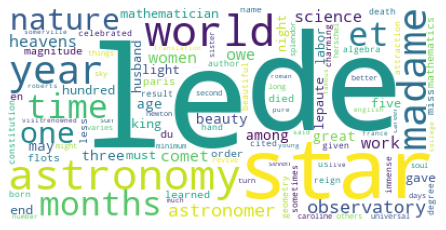

In [64]:
#getting wrong word predictions
wrong_pred = str(wrong_pred_df.loc[wrong_pred_df['Label']=='c']['Partition Text'].str.cat(sep=' '))

#displaying the wrong predicitons words
wordcloud = WordCloud(background_color ='white',
                min_font_size = 5).generate(wrong_pred)
 
# plot the WordCloud image                      
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

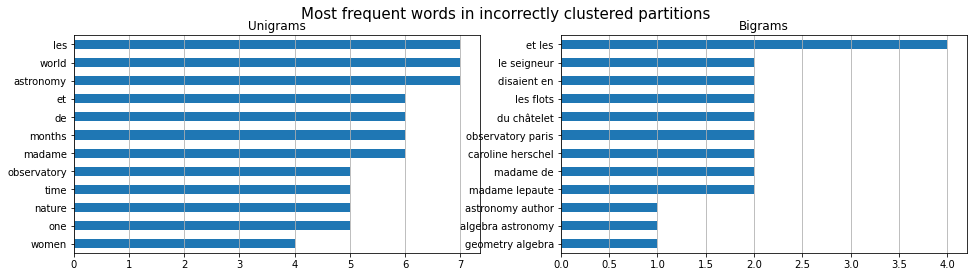

In [65]:

## for vectorizer
from sklearn import feature_extraction, manifold

top = 12
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
fig.suptitle(f'Most frequent words in incorrectly clustered partitions', fontsize=15)
## unigrams
corpus = wrong_pred_df.loc[wrong_pred_df['Label']=='c']['Partition Text']
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
dic_words_freq = nltk.FreqDist(lst_tokens)

dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
ax[0].set(ylabel=None)
      
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                    kind="barh", title="Bigrams", ax=ax[1],
                    legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()


In [66]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(books_df['Partition Text'])
tokens= count_vect.get_feature_names_out()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.toarray()
df_idf = pd.DataFrame(tf_transformer.idf_, index=tokens,columns=["idf_weights"])
df_idf.loc[dtf_uni.iloc[:top,:].sort_values(by="Freq")['Word']].sort_values(by="idf_weights")

,idf_weights
one,1.467808
time,2.017111
nature,2.778856
world,2.858899
de,3.129631
months,3.976929
astronomy,4.730701
women,4.864232
observatory,5.136166
madame,5.423848


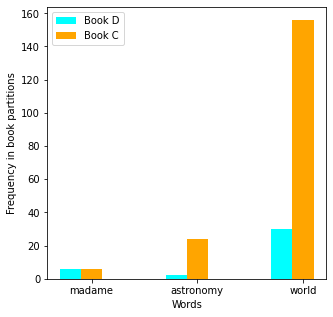

In [67]:
important_words = ["madame","astronomy","world"]
word_count_d=[]
word_count_c=[]

#getting book d paritions
books_df_d = books_df.loc[books_df['Label']=='d']
#getting book c paritions
books_df_c = books_df.loc[books_df['Label']=='c']
#counting the number of occurences of the word astronomy
d_text = str(books_df_d['Partition Text'].str.cat(sep=' '))
c_text = str(books_df_c['Partition Text'].str.cat(sep=' '))

for word in important_words:
  word_count_d.append(d_text.count(word))
  word_count_c.append(c_text.count(word))

fig = plt.figure(figsize = (5, 5))

x = np.arange(3)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, word_count_d, width, color='cyan',label="Book D")
plt.bar(x, word_count_c, width, color='orange',label="Book C")
plt.xticks(x, important_words)
plt.xlabel("Words")
plt.ylabel("Frequency in book partitions")
plt.legend()
plt.show()


In [68]:
books_df_d = books_df.loc[books_df['Label']=='d']
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(books_df_d['Partition Text'])
tokens= count_vect.get_feature_names_out()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.toarray()
df_idf = pd.DataFrame(tf_transformer.idf_, index=tokens,columns=["idf_weights"])
df_idf.loc[df_idf.index.isin(important_words) ].sort_values(by="idf_weights")

,idf_weights
world,3.007468
madame,4.357395
astronomy,5.204693


In [69]:
books_df_c = books_df.loc[books_df['Label']=='c']
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(books_df_c['Partition Text'])
tokens= count_vect.get_feature_names_out()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.toarray()
df_idf = pd.DataFrame(tf_transformer.idf_, index=tokens,columns=["idf_weights"])
df_idf.loc[df_idf.index.isin(important_words)].sort_values(by="idf_weights")

,idf_weights
world,1.985817
astronomy,3.258782
madame,4.693867
